# Import Libraries

In [32]:
#+---- Basic Libraries ----+#
import sys, os, time, gc, random
from pathlib import Path
import pandas as pd
import numpy as np
import copy
from utils import *

#+---- Utilities Libraries ----+#
#import albumentations as albu
import pretrainedmodels
from efficientnet_pytorch import EfficientNet
from iterstrat.ml_stratifiers import MultilabelStratifiedKFold
from PIL import Image
from tqdm.notebook import tqdm
import sklearn
import seaborn as sns
import matplotlib.pyplot as plt

#+---- Pytorch Libraries ----+#
import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
from torch.utils import model_zoo
import numpy as np
import torchvision
from torchvision import datasets, models, transforms
from torch.utils.data import Dataset, DataLoader
from torch.nn import functional as F

#+---- List the input data ----+#
for dirname, _, filenames in os.walk('../../input/'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# Any results you write to the current directory are saved as output.

../../input/train.csv
../../input/test.csv
../../input/class_map.csv
../../input/.gitkeep
../../input/sample_submission.csv
../../input/parquet/train_image_data_2.parquet
../../input/parquet/test_image_data_2.parquet
../../input/parquet/train_image_data_3.parquet
../../input/parquet/test_image_data_1.parquet
../../input/parquet/test_image_data_0.parquet
../../input/parquet/test_image_data_3.parquet
../../input/parquet/train_image_data_0.parquet
../../input/parquet/train_image_data_1.parquet
../../input/feather/train_image_data_2.feather
../../input/feather/test_image_data_1.feather
../../input/feather/train_image_data_1.feather
../../input/feather/test_image_data_3.feather
../../input/feather/train_image_data_0.feather
../../input/feather/test_image_data_0.feather
../../input/feather/test_image_data_2.feather
../../input/feather/train_image_data_3.feather


# Initial Settings

## Directories

In [2]:
DATADIR = Path('../../input')
FEATHERDIR = Path('../../input/feather')
OUTDIR = Path('../../output')
os.listdir('../../')

['input', '.gitignore', 'README.md', '.git', 'src', 'submission', 'output']

## Learning Parameters

In [33]:
DEBUG =False
SUBMISSION =False
BATCH_SIZE =64
NUM_EPOCH = 48
DEVICE = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
MDL_DIR = '../models'
LOG_DIR = '../logs'
IMAGE_SIZE=128
TRAIN_RATIO = 0.9
WORKER = 4
SEED = 6666
MODEL_NAME ='efficientnet-b4'
N_Fold = 10
CV = True
Fold = 1
PATIAENCE = 4
VER = 'fold_1_mixup_cutmix_recall'

In [34]:
n_grapheme = 168
n_vowel = 11
n_consonant = 7
n_total = n_grapheme + n_vowel + n_consonant

# Dataset

## Transform class for data preprocessing and augmentations

In [5]:
def prepare_image(datadir, featherdir, data_type='train',
                  submission=False, indices=[0, 1, 2, 3]):
    assert data_type in ['train', 'test']
    if submission:
        image_df_list = [pd.read_parquet(datadir / f'{data_type}_image_data_{i}.parquet')
                         for i in indices]
    else:
        image_df_list = [pd.read_feather(featherdir / f'{data_type}_image_data_{i}.feather')
                         for i in indices]

    print('image_df_list', len(image_df_list))
    HEIGHT = 137
    WIDTH = 236
    images = [df.iloc[:, 1:].values.reshape(-1, HEIGHT, WIDTH) for df in image_df_list]
    del image_df_list
    gc.collect()
    images = np.concatenate(images, axis=0)
    return images

In [6]:
def crop_char_image(image, threshold=5./255.):
    assert image.ndim == 2
    is_black = image > threshold

    is_black_vertical = np.sum(is_black, axis=0) > 0
    is_black_horizontal = np.sum(is_black, axis=1) > 0
    left = np.argmax(is_black_horizontal)
    right = np.argmax(is_black_horizontal[::-1])
    top = np.argmax(is_black_vertical)
    bottom = np.argmax(is_black_vertical[::-1])
    height, width = image.shape
    cropped_image = image[left:height - right, top:width - bottom]
    return cropped_image

In [7]:
data_transforms = {
    'train': transforms.Compose([
        #transforms.ToPILImage(),
        transforms.ColorJitter(0.5,0.5,0.5,0.5),
        transforms.RandomAffine(degrees=0.6),
        transforms.Resize((IMAGE_SIZE,IMAGE_SIZE)),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225]),
    
    ]),
    'val': transforms.Compose([
        #transforms.ToPILImage(),
        transforms.Resize((IMAGE_SIZE,IMAGE_SIZE)),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    'test': transforms.Compose([
        #transforms.ToPILImage(),
        transforms.Resize((IMAGE_SIZE,IMAGE_SIZE)),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ])
}

In [8]:
class BengaliAIDataset(Dataset):
    def __init__(self, images, labels=None, transform=None, indices=None):
        self.transform = transform
        self.images = images
        self.labels = labels
        if indices is None:
            indices = np.arange(len(images))
        self.indices = indices
        self.train = labels is not None

    def __len__(self):
        """return length of this dataset"""
        return len(self.indices)
      
    def __getitem__(self, i):
        """Return i-th data"""
        i = self.indices[i]
        x = self.images[i]
        # Opposite white and black: background will be white and
        # for future Affine transformation
        x = (255 - x).astype(np.float32) #/ 255.
        x = crop_char_image(x)
        x = Image.fromarray(x).convert("RGB")
        x = self.transform(x)
        if self.train:
            y = self.labels[i]
            return x, y
        else:
            return x

## Import Data

In [35]:
train = pd.read_csv(DATADIR/'train.csv')
train['id'] = train['image_id'].apply(lambda x: int(x.split('_')[1]))
X, y = train[['id', 'grapheme_root', 'vowel_diacritic', 'consonant_diacritic']]\
.values[:,0], train.values[:,1:]
train['fold'] = np.nan
mskf = MultilabelStratifiedKFold(n_splits=N_Fold)
for i, (_, index) in enumerate(mskf.split(X, y)):
    print('Fold '+str(i+1))
    train.iloc[index, -1] = i
train['fold'] = train['fold'].astype('int')

Fold 1
Fold 2
Fold 3
Fold 4
Fold 5
Fold 6
Fold 7
Fold 8
Fold 9
Fold 10


In [36]:
%%time
#train = pd.read_csv(DATADIR/'train.csv')
train_labels = train[['grapheme_root', 'vowel_diacritic', 'consonant_diacritic']].values
indices = [0] if DEBUG else [0, 1, 2, 3]
train_images = prepare_image(
    DATADIR, FEATHERDIR, data_type='train', submission=False, indices=indices)

image_df_list 4
CPU times: user 11.1 s, sys: 12.3 s, total: 23.3 s
Wall time: 13.4 s


In [37]:
n_dataset = len(train_images)

if not CV:
    train_data_size = 200 if DEBUG else int(n_dataset * TRAIN_RATIO)
    valid_data_size = 100 if DEBUG else int(n_dataset - train_data_size)
    perm = np.random.RandomState(777).permutation(n_dataset)
    print('perm', perm)

    train_dataset = BengaliAIDataset(
        train_images, train_labels, transform=data_transforms['train'],
        indices=perm[:train_data_size])

    valid_dataset = BengaliAIDataset(
        train_images, train_labels, transform=data_transforms['val'],
        indices=perm[train_data_size:train_data_size+valid_data_size])
else:
    valid_idx = np.array(train[train['fold']==Fold].index)
    trn_idx = np.array(train[train['fold']!=Fold].index)
    trn_idx = trn_idx[:200] if DEBUG else trn_idx
    valid_idx = valid_idx[:100] if DEBUG else valid_idx
    
    train_dataset = BengaliAIDataset(
        train_images, train_labels, transform=data_transforms['train'],
        indices=trn_idx)
    valid_dataset = BengaliAIDataset(
        train_images, train_labels, transform=data_transforms['val'],
        indices=valid_idx)

train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=WORKER)
valid_loader = DataLoader(valid_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=WORKER)

dataloaders = {'train':train_loader, 'val': valid_loader}
dataset_sizes = {'train':len(train_dataset), 'val': len(valid_dataset)}

In [38]:
image, label = train_dataset[1]
print('image', image.shape, 'label', label)

image torch.Size([3, 128, 128]) label [159   0   0]


# Define Model/Train functions

In [17]:
def macro_recall(pred_labels, y, n_grapheme=168, n_vowel=11, n_consonant=7):
    recall_grapheme = sklearn.metrics.recall_score(y[0], pred_labels[0],  average='macro')
    recall_vowel = sklearn.metrics.recall_score(y[1],pred_labels[1], average='macro')
    recall_consonant = sklearn.metrics.recall_score(y[2],pred_labels[2],  average='macro')
    scores = [recall_grapheme, recall_vowel, recall_consonant]
    final_score = np.average(scores, weights=[2, 1, 1])
    #print(f'recall: grapheme {recall_grapheme}, vowel {recall_vowel}, consonant {recall_consonant}, '
     #      f'total {final_score}')
    return final_score

In [14]:
def get_pred(preds_list, label_list):
    #preds_list is torch tensor to device
    #label_list is torch tensor to device
    _, pred0 = torch.max(preds_list[0], 1)
    _, pred1 = torch.max(preds_list[1], 1)
    _, pred2 = torch.max(preds_list[2], 1)
    p0 = pred0.cpu().numpy()
    p1 = pred1.cpu().numpy()
    p2 = pred2.cpu().numpy()
    pred_labels = [p0, p1, p2]
    #print(pred_labels)
    a0 = label_list[0].cpu().numpy()
    a1 = label_list[1].cpu().numpy()
    a2 = label_list[2].cpu().numpy() 
    y = [a0, a1, a2]
    #print(y)
    return pred_labels, y

In [15]:
def rand_bbox(size, lam):
    W = size[2]
    H = size[3]
    cut_rat = np.sqrt(1. - lam)
    cut_w = np.int(W * cut_rat)
    cut_h = np.int(H * cut_rat)

    # uniform
    cx = np.random.randint(W)
    cy = np.random.randint(H)

    bbx1 = np.clip(cx - cut_w // 2, 0, W)
    bby1 = np.clip(cy - cut_h // 2, 0, H)
    bbx2 = np.clip(cx + cut_w // 2, 0, W)
    bby2 = np.clip(cy + cut_h // 2, 0, H)

    return bbx1, bby1, bbx2, bby2
def cutmix(data, targets1, targets2, targets3, alpha):
    indices = torch.randperm(data.size(0))
    shuffled_data = data[indices]
    shuffled_targets1 = targets1[indices]
    shuffled_targets2 = targets2[indices]
    shuffled_targets3 = targets3[indices]

    lam = np.random.beta(alpha, alpha)
    bbx1, bby1, bbx2, bby2 = rand_bbox(data.size(), lam)
    data[:, :, bbx1:bbx2, bby1:bby2] = data[indices, :, bbx1:bbx2, bby1:bby2]
    # adjust lambda to exactly match pixel ratio
    lam = 1 - ((bbx2 - bbx1) * (bby2 - bby1) / (data.size()[-1] * data.size()[-2]))

    targets = [targets1, shuffled_targets1, targets2, shuffled_targets2, targets3, \
               shuffled_targets3, lam]
    return data, targets

def mixup(data, targets1, targets2, targets3, alpha):
    indices = torch.randperm(data.size(0))
    shuffled_data = data[indices]
    shuffled_targets1 = targets1[indices]
    shuffled_targets2 = targets2[indices]
    shuffled_targets3 = targets3[indices]

    lam = np.random.beta(alpha, alpha)
    data = data * lam + shuffled_data * (1 - lam)
    targets = [targets1, shuffled_targets1, targets2, shuffled_targets2, targets3,\
               shuffled_targets3, lam]

    return data, targets


def cutmix_criterion(preds1,preds2,preds3, targets):
    targets1, targets2,targets3, targets4,targets5, targets6, lam = targets[0], targets[1],\
    targets[2], targets[3], targets[4], targets[5], targets[6]
    criterion = nn.CrossEntropyLoss(reduction='mean')
    return lam * criterion(preds1, targets1) + (1 - lam) * criterion(preds1, targets2) +\
lam * criterion(preds2, targets3) + (1 - lam) * criterion(preds2, targets4) +\
lam * criterion(preds3, targets5) + (1 - lam) * criterion(preds3, targets6)

def mixup_criterion(preds1,preds2,preds3, targets):
    targets1, targets2,targets3, targets4,targets5, targets6, lam = targets[0], \
    targets[1], targets[2], targets[3], targets[4], targets[5], targets[6]
    criterion = nn.CrossEntropyLoss(reduction='mean')
    return lam * criterion(preds1, targets1) + (1 - lam) * criterion(preds1, targets2)\
+ lam * criterion(preds2, targets3) + (1 - lam) * criterion(preds2, targets4) +\
lam * criterion(preds3, targets5) + (1 - lam) * criterion(preds3, targets6)

In [62]:
def train_model(model, dataloaders, criterion, optimizer, scheduler,start_epoch,
                num_epochs, device, patiance):
    since = time.time()
    
    trn_loss_list =[]
    trn_acc_list = []
    val_loss_list =[]
    val_acc_list = []
    epoch_list = []
    recall_list = []
    mix_cnt = 0
    cut_cnt = 0

    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0
    best_loss = 10
    best_recall = 0.0
    torch.backends.cudnn.benchmark = True
    early_stopping_counter = 0
    
    for epoch in range(num_epochs)[start_epoch:]:
        print('Epoch {}/{}'.format(epoch+1, num_epochs))
        print('-' * 30)  
        
        if early_stopping_counter == patiance:
            print(f'Early Stopped since loss have not decreased for {patiance} epoch.')
            break
        epoch_list.append(epoch+1)
        # Each epoch has a training and validation phase
        for phase in ['train', 'val']:
            if phase == 'train':
                model.train()  # Set model to training mode
            else:
                model.eval()   # Set model to evaluate mode

            epoch_loss = 0.0
            epoch_corrects = 0
            dataset_sizes = len(dataloaders[phase].dataset)
            length = int(np.floor(dataset_sizes/BATCH_SIZE))
            ratio = 0.15
            randomlist = random.sample( range(length), int(ratio*length))
            mixuplist = randomlist[:int(ratio*length/2)]
            cutmixlist = randomlist[int(ratio*length/2):]

            # Iterate over data.
            for idx, (inputs, labels) in enumerate(tqdm(dataloaders[phase])):
                #print(inputs.shape)
                inputs = inputs.to(device)
                labels = labels.transpose(1,0).to(device) #use when single label for one image

                grapheme_root = labels[0]
                vowel_diacritic = labels[1]
                consonant_diacritic = labels[2]
                
                # zero the parameter gradients
                optimizer.zero_grad()

                # Forward
                # track history if only in train
                with torch.set_grad_enabled(phase == 'train'):                                 
                    if phase == 'train':
                        if idx in mixuplist:
                            mix_cnt += 1
                            inputs_mixed, labels_mixed = mixup(inputs, grapheme_root, \
                                                               vowel_diacritic, consonant_diacritic, 0.2)

                            outputs = model(inputs_mixed) 
                            grapheme_root_prd = outputs[0]
                            vowel_diacritic_prd = outputs[1]
                            consonant_diacritic_prd = outputs[2]
                            loss = mixup_criterion(grapheme_root_prd,vowel_diacritic_prd,\
                                               consonant_diacritic_prd, labels_mixed)
                            
                        elif idx in cutmixlist:
                            cut_cnt += 1
                            inputs_cut, labels_cut = cutmix(inputs, grapheme_root, \
                                                               vowel_diacritic, consonant_diacritic, 0.2)

                            outputs = model(inputs_cut) 
                            grapheme_root_prd = outputs[0]
                            vowel_diacritic_prd = outputs[1]
                            consonant_diacritic_prd = outputs[2]
                            loss = cutmix_criterion(grapheme_root_prd,vowel_diacritic_prd,\
                                               consonant_diacritic_prd, labels_cut)
                        
                        else:
                            outputs = model(inputs)
                            grapheme_root_prd = outputs[0]
                            vowel_diacritic_prd = outputs[1]
                            consonant_diacritic_prd = outputs[2]
                            loss = (1/3)*(criterion(grapheme_root_prd, grapheme_root)+\
                                  criterion(vowel_diacritic_prd, vowel_diacritic) +\
                                     criterion(consonant_diacritic_prd, consonant_diacritic))
                        loss.backward()
                        optimizer.step()
                    if phase == 'val':
                        outputs = model(inputs)
                        grapheme_root_prd = outputs[0]
                        vowel_diacritic_prd = outputs[1]
                        consonant_diacritic_prd = outputs[2]
                        loss = (1/3)*(criterion(grapheme_root_prd, grapheme_root)+\
                              criterion(vowel_diacritic_prd, vowel_diacritic) +\
                                 criterion(consonant_diacritic_prd, consonant_diacritic))
                        #scheduler.step()
                        # if plateau scheduler use following
                        
                # statistics: inputs.size(0) is batch size
                epoch_loss += loss.item() * inputs.size(0) # total loss for this batch
                epoch_corrects += torch.sum(torch.max(outputs[0], 1)[1] == labels[0])+\
                    torch.sum(torch.max(outputs[1], 1)[1] == labels[1])+\
                    torch.sum(torch.max(outputs[2], 1)[1] == labels[2])
                
            epoch_loss = epoch_loss / dataset_sizes
            epoch_acc = epoch_corrects.double() / (dataset_sizes*3)
            pred, lbls = get_pred(outputs, labels)
            recall = macro_recall(pred, lbls, \
                                      n_grapheme=168, n_vowel=11, n_consonant=7)
            
            if phase == 'train':
                trn_loss_list.append(epoch_loss)
                trn_acc_list.append(epoch_acc.cpu().numpy())

            print('{} Loss: {:.4f} Acc: {:.4f}'.format(
                phase, epoch_loss, epoch_acc))

            # Deep copy the model
            if phase == 'val' and recall > best_recall:
                best_model_wts = copy.deepcopy(model.state_dict())
                if not os.path.exists(f'{MDL_DIR}/{MODEL_NAME}_{VER}'):
                    os.mkdir(f'{MDL_DIR}/{MODEL_NAME}_{VER}')
                save_path = f'{MDL_DIR}/{MODEL_NAME}_{VER}/{MODEL_NAME}_'+str(epoch+1)+'.pth'
                torch.save(model_ft.state_dict(),save_path)
                best_epoch = epoch
            
            if phase == 'val':
                if epoch == 0 or epoch == start_epoch:
                    best_recall = recall
                    
                else:
                    if recall > best_recall:
                        print(recall)
                        best_recall = recall
                        early_stopping_counter = 0
                    else:
                        early_stopping_counter += 1
                        print(f'Early stopping counter: {early_stopping_counter}')

                scheduler.step(1-recall)
                val_loss_list.append(epoch_loss)
                val_acc_list.append(epoch_acc.cpu().numpy())
                print(mix_cnt, cut_cnt)
                mix_cnt = 0
                cut_cnt = 0
                
                
                print('valid recall score is {:.3f}'.format(recall))
                recall_list.append(recall)

        
    time_elapsed = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(
        time_elapsed // 60, time_elapsed % 60))
    print('Best val Recall: {:4f}'.format(best_recall))

    # load best model weights
    model.load_state_dict(best_model_wts)
    if not DEBUG:
        if not os.path.exists(f'{LOG_DIR}/log_{MODEL_NAME}_{VER}.csv'):
            log = pd.DataFrame()
            log['Epoch'] = epoch_list
            log['Train Loss'] = trn_loss_list
            log['Train Acc'] = trn_acc_list
            log['Valid Loss'] = val_loss_list
            log['Valid Acc'] = val_acc_list
            log['Recall'] = recall_list
            log.to_csv(f'{LOG_DIR}/log_{MODEL_NAME}_{VER}.csv',index=False)
        else:
            log = pd.DataFrame()
            log['Epoch'] = epoch_list
            log['Train Loss'] = trn_loss_list
            log['Train Acc'] = trn_acc_list
            log['Valid Loss'] = val_loss_list
            log['Valid Acc'] = val_acc_list
            log['Recall'] = recall_list
            log_old = pd.read_csv(f'{LOG_DIR}/log_{MODEL_NAME}_{VER}.csv')
            LOG = pd.concat([log_old, log], axis=0)
            LOG.reset_index(drop=True, inplace=True)
            LOG.to_csv(f'{LOG_DIR}/log_{MODEL_NAME}_{VER}.csv',index=False)
    return model, best_epoch

In [20]:
class bengali_model(nn.Module):
    def __init__(self, num_classes1, num_classes2, num_classes3):
        super(bengali_model, self).__init__()
        #pretrain models
        #self.model = pretrainedmodels.__dict__[MODEL_NAME](pretrained=None)
        #num_ftrs = self.model.last_linear.in_features
        #self.model.last_linear = nn.Identity()
        
        # EfficientNet
        self.model = EfficientNet.from_pretrained(MODEL_NAME)
        num_ftrs = 1792
        
        self.fc1 = nn.Linear(num_ftrs, num_classes1)
        self.fc2 = nn.Linear(num_ftrs, num_classes2)
        self.fc3 = nn.Linear(num_ftrs, num_classes3)

    def forward(self, x):
        #x = self.model(x) #pretrain models
        bs, _, _, _ = x.shape
        x = self.model.extract_features(x)
        x = F.adaptive_avg_pool2d(x, 1).reshape(bs, -1)
        out1 = self.fc1(x)
        out2 = self.fc2(x)
        out3 = self.fc3(x)
        return out1, out2, out3

In [26]:
# --- Model --- Stage 1
model_ft = bengali_model(n_grapheme, n_vowel, n_consonant)
model_ft = model_ft.to(DEVICE)

#criterion = nn.BCEWithLogitsLoss()
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model_ft.parameters(), lr=0.001)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(
    optimizer, mode='min', factor=0.5, patience=2, min_lr=1e-10, verbose=True)

Loaded pretrained weights for efficientnet-b4


In [40]:
torch.cuda.empty_cache()
gc.collect()

20

In [ ]:
model_ft, best_epoch = train_model(model_ft, dataloaders, criterion, optimizer, scheduler,0, NUM_EPOCH, DEVICE, PATIAENCE)

Epoch 1/48
------------------------------



train Loss: 1.8916 Acc: 0.6580


/home/ryoooo1114/anaconda3/envs/analysis/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))



val Loss: 0.5840 Acc: 0.8602
211 212
valid recall score is 0.658
Epoch 2/48
------------------------------



train Loss: 1.0252 Acc: 0.8310



val Loss: 0.2960 Acc: 0.9289
0.8287037037037037
211 212
valid recall score is 0.829
Epoch 3/48
------------------------------



train Loss: 0.7788 Acc: 0.8743



val Loss: 0.2084 Acc: 0.9480
Early stopping counter: 1
211 212
valid recall score is 0.829
Epoch 4/48
------------------------------



train Loss: 0.7115 Acc: 0.8920



val Loss: 0.1808 Acc: 0.9548
0.8398148148148148
211 212
valid recall score is 0.840
Epoch 5/48
------------------------------



train Loss: 0.6669 Acc: 0.8966



val Loss: 0.1641 Acc: 0.9594
0.8817829457364341
211 212
valid recall score is 0.882
Epoch 6/48
------------------------------



train Loss: 0.5743 Acc: 0.9061



val Loss: 0.1392 Acc: 0.9631
0.8992248062015503
211 212
valid recall score is 0.899
Epoch 7/48
------------------------------



train Loss: 0.5414 Acc: 0.9103



val Loss: 0.1246 Acc: 0.9646
0.9349593495934959
211 212
valid recall score is 0.935
Epoch 8/48
------------------------------



train Loss: 0.5062 Acc: 0.9182



val Loss: 0.1185 Acc: 0.9662
Early stopping counter: 1
211 212
valid recall score is 0.935
Epoch 9/48
------------------------------



train Loss: 0.4825 Acc: 0.9204



val Loss: 0.1125 Acc: 0.9684
0.95
211 212
valid recall score is 0.950
Epoch 10/48
------------------------------



train Loss: 0.4633 Acc: 0.9233



val Loss: 0.1109 Acc: 0.9687
Early stopping counter: 1
211 212
valid recall score is 0.909
Epoch 11/48
------------------------------



train Loss: 0.4529 Acc: 0.9230



val Loss: 0.1065 Acc: 0.9699
Early stopping counter: 2
211 212
valid recall score is 0.917
Epoch 12/48
------------------------------



train Loss: 0.4448 Acc: 0.9261



val Loss: 0.1049 Acc: 0.9704
0.9520833333333333
211 212
valid recall score is 0.952
Epoch 13/48
------------------------------



train Loss: 0.4434 Acc: 0.9295



val Loss: 0.1029 Acc: 0.9712
0.967948717948718
211 212
valid recall score is 0.968
Epoch 14/48
------------------------------



train Loss: 0.4467 Acc: 0.9278



val Loss: 0.1022 Acc: 0.9718
Early stopping counter: 1
211 212
valid recall score is 0.952
Epoch 15/48
------------------------------



train Loss: 0.4346 Acc: 0.9286



val Loss: 0.1026 Acc: 0.9716
Early stopping counter: 2
211 212
valid recall score is 0.929
Epoch 16/48
------------------------------


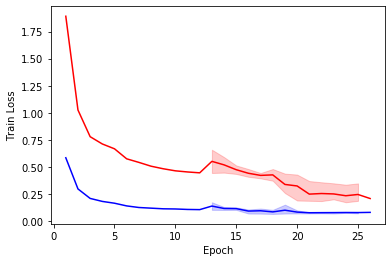

In [87]:
log = pd.read_csv(f'{LOG_DIR}/log_{MODEL_NAME}_{VER}.csv')
sns.lineplot(x=log['Epoch'], y=log['Valid Loss'], color='blue')
sns.lineplot(x=log['Epoch'], y=log['Train Loss'], color='red')
#sns.lineplot(x=log['Epoch'], y=log['Recall'], color='green')
plt.show()

In [88]:
log

,Epoch,Train Loss,Train Acc,Valid Loss,Valid Acc,Recall
0,1,1.891603,0.658047,0.584045,0.860237,0.658109
1,2,1.025216,0.830978,0.296039,0.928915,0.828704
2,3,0.778765,0.874254,0.208433,0.948002,0.828704
3,4,0.711464,0.891989,0.180765,0.954840,0.839815
4,5,0.666884,0.896612,0.164109,0.959371,0.881783
5,6,0.574321,0.906074,0.139226,0.963088,0.899225
6,7,0.541422,0.910308,0.124557,0.964582,0.934959
7,8,0.506225,0.918232,0.118499,0.966192,0.934959
8,9,0.482486,0.920408,0.112499,0.968416,0.950000
9,10,0.463328,0.923326,0.110900,0.968715,0.908730


In [46]:
# --- Model --- Stage 2

model_ft = model_ft.to(DEVICE)

save_path = f'{MDL_DIR}/{MODEL_NAME}_{VER}/{MODEL_NAME}_'+str(best_epoch+1)+'.pth'
load_weights = torch.load(save_path)
model_ft.load_state_dict(load_weights)

#criterion = nn.BCEWithLogitsLoss()
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model_ft.parameters(), lr=0.0005)

scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(
    optimizer, mode='min', factor=0.7, patience=2, min_lr=1e-10, verbose=True)

In [48]:
model_ft, best_epoch = train_model(model_ft, dataloaders, criterion, optimizer, scheduler,best_epoch, NUM_EPOCH, DEVICE, PATIAENCE)

Epoch 13/48
------------------------------



train Loss: 0.6584 Acc: 0.8838


/home/ryoooo1114/anaconda3/envs/analysis/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))



val Loss: 0.1726 Acc: 0.9511
211 212
valid recall score is 0.884
Epoch 14/48
------------------------------



train Loss: 0.5901 Acc: 0.9036



val Loss: 0.1286 Acc: 0.9634
0.9210840108401085
211 212
valid recall score is 0.921
Epoch 15/48
------------------------------



train Loss: 0.5129 Acc: 0.9141



val Loss: 0.1257 Acc: 0.9644
0.9443766937669377
211 212
valid recall score is 0.944
Epoch 16/48
------------------------------



train Loss: 0.4798 Acc: 0.9178



val Loss: 0.1061 Acc: 0.9703
0.9833333333333334
211 212
valid recall score is 0.983
Epoch 17/48
------------------------------



train Loss: 0.4432 Acc: 0.9168



val Loss: 0.1146 Acc: 0.9683
Early stopping counter: 1
211 212
valid recall score is 0.953
Epoch 18/48
------------------------------



train Loss: 0.4799 Acc: 0.9230



val Loss: 0.1027 Acc: 0.9715
Early stopping counter: 2
211 212
valid recall score is 0.969
Epoch 19/48
------------------------------



train Loss: 0.4374 Acc: 0.9255



val Loss: 0.1507 Acc: 0.9599
Early stopping counter: 3
211 212
valid recall score is 0.964
Epoch 20/48
------------------------------



train Loss: 0.4286 Acc: 0.9271



val Loss: 0.0979 Acc: 0.9734
Early stopping counter: 4
211 212
valid recall score is 0.926
Epoch 21/48
------------------------------
Early Stopped since loss have not decreased for 4 epoch.
Training complete in 381m 19s
Best val Recall: 0.983333


In [63]:
# --- Model --- Stage 3

model_ft = model_ft.to(DEVICE)

save_path = f'{MDL_DIR}/{MODEL_NAME}_{VER}/{MODEL_NAME}_'+str(best_epoch+1)+'.pth'
load_weights = torch.load(save_path)
model_ft.load_state_dict(load_weights)

#criterion = nn.BCEWithLogitsLoss()
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model_ft.parameters(), lr=0.0001)

scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(
    optimizer, mode='min', factor=0.5, patience=2, min_lr=1e-10, verbose=True)

In [64]:
PATIAENCE = 6
model_ft, best_epoch = train_model(model_ft, dataloaders, criterion, optimizer, scheduler,best_epoch, NUM_EPOCH, DEVICE, PATIAENCE)

Epoch 16/48
------------------------------



train Loss: 0.4081 Acc: 0.9306



val Loss: 0.0686 Acc: 0.9804
211 212
valid recall score is 0.987
Epoch 17/48
------------------------------



train Loss: 0.3939 Acc: 0.9336


/home/ryoooo1114/anaconda3/envs/analysis/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))



val Loss: 0.0681 Acc: 0.9816
Early stopping counter: 1
211 212
valid recall score is 0.987
Epoch 18/48
------------------------------



train Loss: 0.3721 Acc: 0.9391



val Loss: 0.0652 Acc: 0.9825
Early stopping counter: 2
211 212
valid recall score is 0.982
Epoch 19/48
------------------------------



train Loss: 0.3718 Acc: 0.9398



val Loss: 0.0688 Acc: 0.9821
1.0
211 212
valid recall score is 1.000
Epoch 20/48
------------------------------



train Loss: 0.3531 Acc: 0.9392



val Loss: 0.0697 Acc: 0.9820
Early stopping counter: 1
211 212
valid recall score is 1.000
Epoch 21/48
------------------------------



train Loss: 0.3688 Acc: 0.9415



val Loss: 0.0699 Acc: 0.9821
Early stopping counter: 2
211 212
valid recall score is 0.987
Epoch 22/48
------------------------------



train Loss: 0.3577 Acc: 0.9426



val Loss: 0.0709 Acc: 0.9820
Early stopping counter: 3
Epoch     7: reducing learning rate of group 0 to 5.0000e-05.
211 212
valid recall score is 0.987
Epoch 23/48
------------------------------



train Loss: 0.3478 Acc: 0.9443



val Loss: 0.0692 Acc: 0.9829
Early stopping counter: 4
211 212
valid recall score is 0.987
Epoch 24/48
------------------------------



train Loss: 0.3351 Acc: 0.9432



val Loss: 0.0727 Acc: 0.9831
Early stopping counter: 5
211 212
valid recall score is 0.987
Epoch 25/48
------------------------------



train Loss: 0.3471 Acc: 0.9424



val Loss: 0.0710 Acc: 0.9828
Early stopping counter: 6
Epoch    10: reducing learning rate of group 0 to 2.5000e-05.
211 212
valid recall score is 0.982
Epoch 26/48
------------------------------
Early Stopped since loss have not decreased for 6 epoch.
Training complete in 476m 27s
Best val Recall: 1.000000


In [74]:
def train_model(model, dataloaders, criterion, optimizer, scheduler,start_epoch,
                num_epochs, device, patiance):
    since = time.time()
    
    trn_loss_list =[]
    trn_acc_list = []
    val_loss_list =[]
    val_acc_list = []
    epoch_list = []
    recall_list = []
    mix_cnt = 0
    cut_cnt = 0

    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0
    best_loss = 10
    torch.backends.cudnn.benchmark = True
    early_stopping_counter = 0
    
    for epoch in range(num_epochs)[start_epoch:]:
        print('Epoch {}/{}'.format(epoch+1, num_epochs))
        print('-' * 30)  
        
        if early_stopping_counter == patiance:
            print(f'Early Stopped since loss have not decreased for {patiance} epoch.')
            break
        epoch_list.append(epoch+1)
        # Each epoch has a training and validation phase
        for phase in ['train', 'val']:
            if phase == 'train':
                model.train()  # Set model to training mode
            else:
                model.eval()   # Set model to evaluate mode

            epoch_loss = 0.0
            epoch_corrects = 0
            dataset_sizes = len(dataloaders[phase].dataset)
            length = int(np.floor(dataset_sizes/BATCH_SIZE))
            ratio = 0.1
            randomlist = random.sample( range(length), int(ratio*length))
            mixuplist = randomlist[:int(ratio*length/2)]
            cutmixlist = randomlist[int(ratio*length/2):]

            # Iterate over data.
            for idx, (inputs, labels) in enumerate(tqdm(dataloaders[phase])):
                #print(inputs.shape)
                inputs = inputs.to(device)
                labels = labels.transpose(1,0).to(device) #use when single label for one image

                grapheme_root = labels[0]
                vowel_diacritic = labels[1]
                consonant_diacritic = labels[2]
                
                # zero the parameter gradients
                optimizer.zero_grad()

                # Forward
                # track history if only in train
                with torch.set_grad_enabled(phase == 'train'):                                 
                    if phase == 'train':
                        if idx in mixuplist:
                            mix_cnt += 1
                            inputs_mixed, labels_mixed = mixup(inputs, grapheme_root, \
                                                               vowel_diacritic, consonant_diacritic, 0.1)

                            outputs = model(inputs_mixed) 
                            grapheme_root_prd = outputs[0]
                            vowel_diacritic_prd = outputs[1]
                            consonant_diacritic_prd = outputs[2]
                            loss = mixup_criterion(grapheme_root_prd,vowel_diacritic_prd,\
                                               consonant_diacritic_prd, labels_mixed)
                            
                        elif idx in cutmixlist:
                            cut_cnt += 1
                            inputs_cut, labels_cut = cutmix(inputs, grapheme_root, \
                                                               vowel_diacritic, consonant_diacritic, 0.1)

                            outputs = model(inputs_cut) 
                            grapheme_root_prd = outputs[0]
                            vowel_diacritic_prd = outputs[1]
                            consonant_diacritic_prd = outputs[2]
                            loss = cutmix_criterion(grapheme_root_prd,vowel_diacritic_prd,\
                                               consonant_diacritic_prd, labels_cut)
                        
                        else:
                            outputs = model(inputs)
                            grapheme_root_prd = outputs[0]
                            vowel_diacritic_prd = outputs[1]
                            consonant_diacritic_prd = outputs[2]
                            loss = (1/4)*(2*criterion(grapheme_root_prd, grapheme_root)+\
                                  criterion(vowel_diacritic_prd, vowel_diacritic) +\
                                     criterion(consonant_diacritic_prd, consonant_diacritic))
                        loss.backward()
                        optimizer.step()
                    if phase == 'val':
                        outputs = model(inputs)
                        grapheme_root_prd = outputs[0]
                        vowel_diacritic_prd = outputs[1]
                        consonant_diacritic_prd = outputs[2]
                        loss = (1/4)*(2*criterion(grapheme_root_prd, grapheme_root)+\
                              criterion(vowel_diacritic_prd, vowel_diacritic) +\
                                 criterion(consonant_diacritic_prd, consonant_diacritic))
                        #scheduler.step()
                        # if plateau scheduler use following
                        
                # statistics: inputs.size(0) is batch size
                epoch_loss += loss.item() * inputs.size(0) # total loss for this batch
                epoch_corrects += torch.sum(torch.max(outputs[0], 1)[1] == labels[0])+\
                    torch.sum(torch.max(outputs[1], 1)[1] == labels[1])+\
                    torch.sum(torch.max(outputs[2], 1)[1] == labels[2])
                
            epoch_loss = epoch_loss / dataset_sizes
            epoch_acc = epoch_corrects.double() / (dataset_sizes*3)
            
            if phase == 'train':
                trn_loss_list.append(epoch_loss)
                trn_acc_list.append(epoch_acc.cpu().numpy())

            print('{} Loss: {:.4f} Acc: {:.4f}'.format(
                phase, epoch_loss, epoch_acc))

            # Deep copy the model
            if phase == 'val' and epoch_loss < best_loss:
                best_model_wts = copy.deepcopy(model.state_dict())
                if not os.path.exists(f'{MDL_DIR}/{MODEL_NAME}_{VER}'):
                    os.mkdir(f'{MDL_DIR}/{MODEL_NAME}_{VER}')
                save_path = f'{MDL_DIR}/{MODEL_NAME}_{VER}/{MODEL_NAME}_'+str(epoch+1)+'.pth'
                torch.save(model_ft.state_dict(),save_path)
                best_epoch = epoch
            
            if phase == 'val':
                if epoch == 0 or epoch == start_epoch:
                    best_loss = epoch_loss
                    print(best_loss)
                else:
                    if epoch_loss < best_loss:
                        print(best_loss)
                        best_loss = epoch_loss
                        early_stopping_counter = 0
                    else:
                        early_stopping_counter += 1
                        print(f'Early stopping counter: {early_stopping_counter}')
                scheduler.step(epoch_loss)
                val_loss_list.append(epoch_loss)
                val_acc_list.append(epoch_acc.cpu().numpy())
                print(mix_cnt, cut_cnt)
                mix_cnt = 0
                cut_cnt = 0
                pred, lbls = get_pred(outputs, labels)
                recall = macro_recall(pred, lbls, \
                                      n_grapheme=168, n_vowel=11, n_consonant=7)
                print('valid recall score is {:.3f}'.format(recall))
                recall_list.append(recall)

        
    time_elapsed = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(
        time_elapsed // 60, time_elapsed % 60))
    print('Best val Loss: {:4f}'.format(best_loss))

    # load best model weights
    model.load_state_dict(best_model_wts)
    if not os.path.exists(f'{LOG_DIR}/log_{MODEL_NAME}_{VER}.csv'):
        log = pd.DataFrame()
        log['Epoch'] = epoch_list
        log['Train Loss'] = trn_loss_list
        log['Train Acc'] = trn_acc_list
        log['Valid Loss'] = val_loss_list
        log['Valid Acc'] = val_acc_list
        log['Recall'] = recall_list
        log.to_csv(f'{LOG_DIR}/log_{MODEL_NAME}_{VER}.csv',index=False)
    else:
        log = pd.DataFrame()
        log['Epoch'] = epoch_list
        log['Train Loss'] = trn_loss_list
        log['Train Acc'] = trn_acc_list
        log['Valid Loss'] = val_loss_list
        log['Valid Acc'] = val_acc_list
        log['Recall'] = recall_list
        log_old = pd.read_csv(f'{LOG_DIR}/log_{MODEL_NAME}_{VER}.csv')
        LOG = pd.concat([log_old, log], axis=0)
        LOG.reset_index(drop=True, inplace=True)
        LOG.to_csv(f'{LOG_DIR}/log_{MODEL_NAME}_{VER}.csv',index=False)
    return model, best_epoch

In [75]:
# --- Model --- Stage 4

model_ft = model_ft.to(DEVICE)

save_path = f'{MDL_DIR}/{MODEL_NAME}_{VER}/{MODEL_NAME}_'+str(best_epoch+1)+'.pth'
load_weights = torch.load(save_path)
model_ft.load_state_dict(load_weights)

#criterion = nn.BCEWithLogitsLoss()
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model_ft.parameters(), lr=0.0000125)

scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, 3, eta_min=0, last_epoch=-1)

In [76]:
PATIAENCE = 6
model_ft, best_epoch = train_model(model_ft, dataloaders, criterion, optimizer, scheduler,best_epoch, NUM_EPOCH, DEVICE, PATIAENCE)

Epoch 19/48
------------------------------



train Loss: 0.2035 Acc: 0.9593



val Loss: 0.0794 Acc: 0.9834
0.07938785859274392
141 141
valid recall score is 1.000
Epoch 20/48
------------------------------



train Loss: 0.1891 Acc: 0.9568



val Loss: 0.0787 Acc: 0.9834
0.07938785859274392
141 141
valid recall score is 0.987
Epoch 21/48
------------------------------



train Loss: 0.1891 Acc: 0.9598



val Loss: 0.0800 Acc: 0.9839
Early stopping counter: 1
141 141
valid recall score is 0.987
Epoch 22/48
------------------------------



train Loss: 0.2194 Acc: 0.9560



val Loss: 0.0806 Acc: 0.9837
Early stopping counter: 2
141 141
valid recall score is 1.000
Epoch 23/48
------------------------------



train Loss: 0.2015 Acc: 0.9596



val Loss: 0.0811 Acc: 0.9836
Early stopping counter: 3
141 141
valid recall score is 0.987
Epoch 24/48
------------------------------



train Loss: 0.1914 Acc: 0.9611



val Loss: 0.0794 Acc: 0.9837
Early stopping counter: 4
141 141
valid recall score is 1.000
Epoch 25/48
------------------------------



train Loss: 0.1858 Acc: 0.9641



val Loss: 0.0805 Acc: 0.9838
Early stopping counter: 5
141 141
valid recall score is 0.987
Epoch 26/48
------------------------------



train Loss: 0.2074 Acc: 0.9617



val Loss: 0.0794 Acc: 0.9838
Early stopping counter: 6
141 141
valid recall score is 1.000
Epoch 27/48
------------------------------
Early Stopped since loss have not decreased for 6 epoch.
Training complete in 380m 14s
Best val Loss: 0.078741


In [81]:
# --- Model --- Stage 5

model_ft = model_ft.to(DEVICE)

save_path = f'{MDL_DIR}/{MODEL_NAME}_{VER}/{MODEL_NAME}_'+str(best_epoch+1)+'.pth'
load_weights = torch.load(save_path)
model_ft.load_state_dict(load_weights)

#criterion = nn.BCEWithLogitsLoss()
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model_ft.parameters(), lr=0.0000125)

scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(
    optimizer, mode='min', factor=0.5, patience=1, min_lr=1e-10, verbose=True)

In [82]:
PATIAENCE = 4
model_ft, best_epoch = train_model(model_ft, dataloaders, criterion, optimizer, scheduler,best_epoch+1, NUM_EPOCH, DEVICE, PATIAENCE)

Epoch 21/48
------------------------------



train Loss: 0.1865 Acc: 0.9611



val Loss: 0.0784 Acc: 0.9839
0.07840094533729448
141 141
valid recall score is 0.987
Epoch 22/48
------------------------------



train Loss: 0.1839 Acc: 0.9610



val Loss: 0.0790 Acc: 0.9839
Early stopping counter: 1
141 141
valid recall score is 0.987
Epoch 23/48
------------------------------



train Loss: 0.2002 Acc: 0.9600



val Loss: 0.0815 Acc: 0.9835
Early stopping counter: 2
Epoch     3: reducing learning rate of group 0 to 6.2500e-06.
141 141
valid recall score is 1.000
Epoch 24/48
------------------------------



train Loss: 0.1730 Acc: 0.9653



val Loss: 0.0823 Acc: 0.9837
Early stopping counter: 3
141 141
valid recall score is 0.987
Epoch 25/48
------------------------------



train Loss: 0.2017 Acc: 0.9599



val Loss: 0.0811 Acc: 0.9838
Early stopping counter: 4
Epoch     5: reducing learning rate of group 0 to 3.1250e-06.
141 141
valid recall score is 0.987
Epoch 26/48
------------------------------
Early Stopped since loss have not decreased for 4 epoch.
Training complete in 237m 30s
Best val Loss: 0.078401


# Evaluation

In [49]:
def predict(model, dataloaders, phase, device):
    model.eval()
    output_list = []
    label_list = []
    with torch.no_grad():
        if phase == 'test':
            for i, inputs in enumerate(tqdm(dataloaders)):
                
                inputs = inputs.to(device)
                outputs = model(inputs)
                _, pred0 = torch.max(outputs[0], 1)
                _, pred1 = torch.max(outputs[1], 1)
                _, pred2 = torch.max(outputs[2], 1)
                preds = (pred0, pred1, pred2)
                output_list.append(preds)
            return output_list
        elif phase == 'val':
            for i, (inputs, labels) in enumerate(tqdm(dataloaders)):
                
                inputs = inputs.to(device)
                outputs = model(inputs)
                _, pred0 = torch.max(outputs[0], 1)
                _, pred1 = torch.max(outputs[1], 1)
                _, pred2 = torch.max(outputs[2], 1)
                preds = (pred0, pred1, pred2)
                output_list.append(preds)
                label_list.append(labels.transpose(1,0))
            return output_list, label_list

In [83]:
best_epoch+1

21

In [84]:
save_path = f'{MDL_DIR}/{MODEL_NAME}_{VER}/{MODEL_NAME}_'+str(best_epoch+1)+'.pth'
load_weights = torch.load(save_path)
model_ft.load_state_dict(load_weights)

<All keys matched successfully>

In [85]:
# --- Prediction ---
data_type = 'val'
valid_preds_list = []
print('valid_dataset', len(valid_dataset))
valid_preds_list, valid_label_list = predict(model_ft, valid_loader, data_type, DEVICE)
gc.collect()

valid_dataset 20084


9

In [86]:
# Each test_preds indicates the prediction outputs of different batch
p0 = np.concatenate([valid_preds[0].cpu().numpy() for valid_preds in valid_preds_list], axis=0)
p1 = np.concatenate([valid_preds[1].cpu().numpy() for valid_preds in valid_preds_list], axis=0)
p2 = np.concatenate([valid_preds[2].cpu().numpy() for valid_preds in valid_preds_list], axis=0)
print('p0', p0.shape, 'p1', p1.shape, 'p2', p2.shape)

a0 = np.concatenate([valid_label[0].cpu().numpy() for valid_label in valid_label_list], axis=0)
a1 = np.concatenate([valid_label[1].cpu().numpy() for valid_label in valid_label_list], axis=0)
a2 = np.concatenate([valid_label[2].cpu().numpy() for valid_label in valid_label_list], axis=0)
print('a0', a0.shape, 'a1', a1.shape, 'a2', a2.shape)

pred_labels = [p0, p1, p2]
y = [a0, a1, a2]
macro_recall(pred_labels, y, n_grapheme=168, n_vowel=11, n_consonant=7)
# 0.9549743301666287
# 0.9748094872681604
# 0.9770678173427654

p0 (20084,) p1 (20084,) p2 (20084,)
a0 (20084,) a1 (20084,) a2 (20084,)


0.9777011040646183

# Inference

In [ ]:
# --- Prediction ---
data_type = 'test'
test_preds_list = []
for i in range(4):
    # --- prepare data ---
    indices = [i]
    test_images = prepare_image(
        DATADIR, FEATHERDIR, data_type = data_type, submission=True, indices=indices)
    n_dataset = len(test_images)
    print(f'i={i}, n_dataset={n_dataset}')
    # test_data_size = 200 if debug else int(n_dataset * 0.9)
    test_dataset = BengaliAIDataset(
    test_images, None,
    transform=data_transforms[data_type])
    print('test_dataset', len(test_dataset))
    test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=WORKER)
    
    test_preds_list = predict(model_ft, test_loader, data_type,DEVICE)
    del test_images
    gc.collect()
    if DEBUG:
        break

In [ ]:
# Each test_preds indicates the prediction outputs of different batch
p0 = np.concatenate([test_preds[0].cpu().numpy() for test_preds in test_preds_list], axis=0)
p1 = np.concatenate([test_preds[1].cpu().numpy() for test_preds in test_preds_list], axis=0)
p2 = np.concatenate([test_preds[2].cpu().numpy() for test_preds in test_preds_list], axis=0)
print('p0', p0.shape, 'p1', p1.shape, 'p2', p2.shape)

row_id = []
target = []
for i in tqdm(range(len(p0))):
    row_id += [f'Test_{i}_grapheme_root', f'Test_{i}_vowel_diacritic',
               f'Test_{i}_consonant_diacritic']
    target += [p0[i], p1[i], p2[i]]
pred_df = pd.DataFrame({'row_id': row_id, 'target': target})

In [ ]:
pred_df.to_csv('submission.csv', index=False)